# Primary-Multiple Curvelet Separation: synthetic data example

Now let's apply both algorithms to synthetic data and compare results, now which are the correct output we would like to obtain (primaries).

*****

**IMPORTANT!**

You need to install curvelops inside the pylops_37 environment due to this package being compatible only with python 3.7. Please follow the instructions written in the github website: https://github.com/DIG-Kaust/conda_envs/blob/main/install_curvelops.sh

The .yml environment file can be found here:
https://github.com/DIG-Kaust/conda_envs/blob/main/environment_pylops_37.yml

Once complete, run this notebook using pylops_37 env.

*****

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from curvelops import FDCT2D
from curvelops.plot import curveshow

import sys
sys.path.append('../adasubtraction/')     # add path to adasubtraction

from curvelet_separation import curvelet_separation
from curvelet_masking import curvelet_masking

## Demultiple syntethic data
Now we will try both approachs on synthetic seismic data. The number of scales and wedges must be higher considering that primaries and multiples have similar velocities, hence it's more difficult to separate them in different wedges.

In [3]:
# Load data

data = np.load('../data/data.npz')['arr_0'][300]
primaries = np.load('../data/primaries.npz')['arr_0'][300]
multiples = np.load('../data/srme_multiples.npz')['arr_0'][1]
true_multiples = np.load('../data/true_multiples.npz')['arr_0'][1]

In [12]:
# ns = data.shape[0]
nr = data.shape[0]
nt = data.shape[1]
dt = 0.004    # time sampling
dx = 10       # space sampling

Create curvelet operator. You must select a sufficient number of scales and wedges to be able to separate multiples and primaries in different wedges, for the purpose of avoiding masking signal as well. 

In [5]:
# Select number of scales and wedges

sc = 10
w_n = 8

# Create Operator

C2D = FDCT2D(data.shape, nbscales=sc, nbangles_coarse=w_n, allcurvelets=False)

In [29]:
# Find how many wedges there are

num = 0
for iscale in data_coefs:
    num += len(iscale)
print(num, 'wedges')

182 wedges


Apply the **masking** in the curvelet domain and plot it. Our input will be the total data and the SRME predicted multiples.

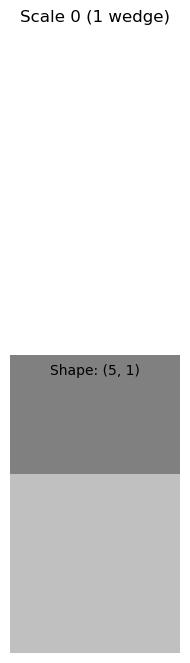

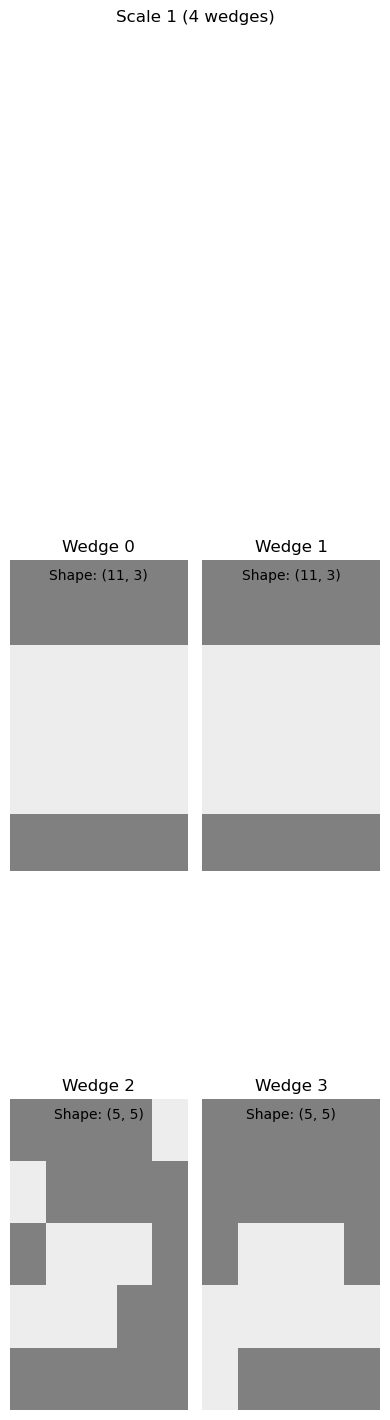

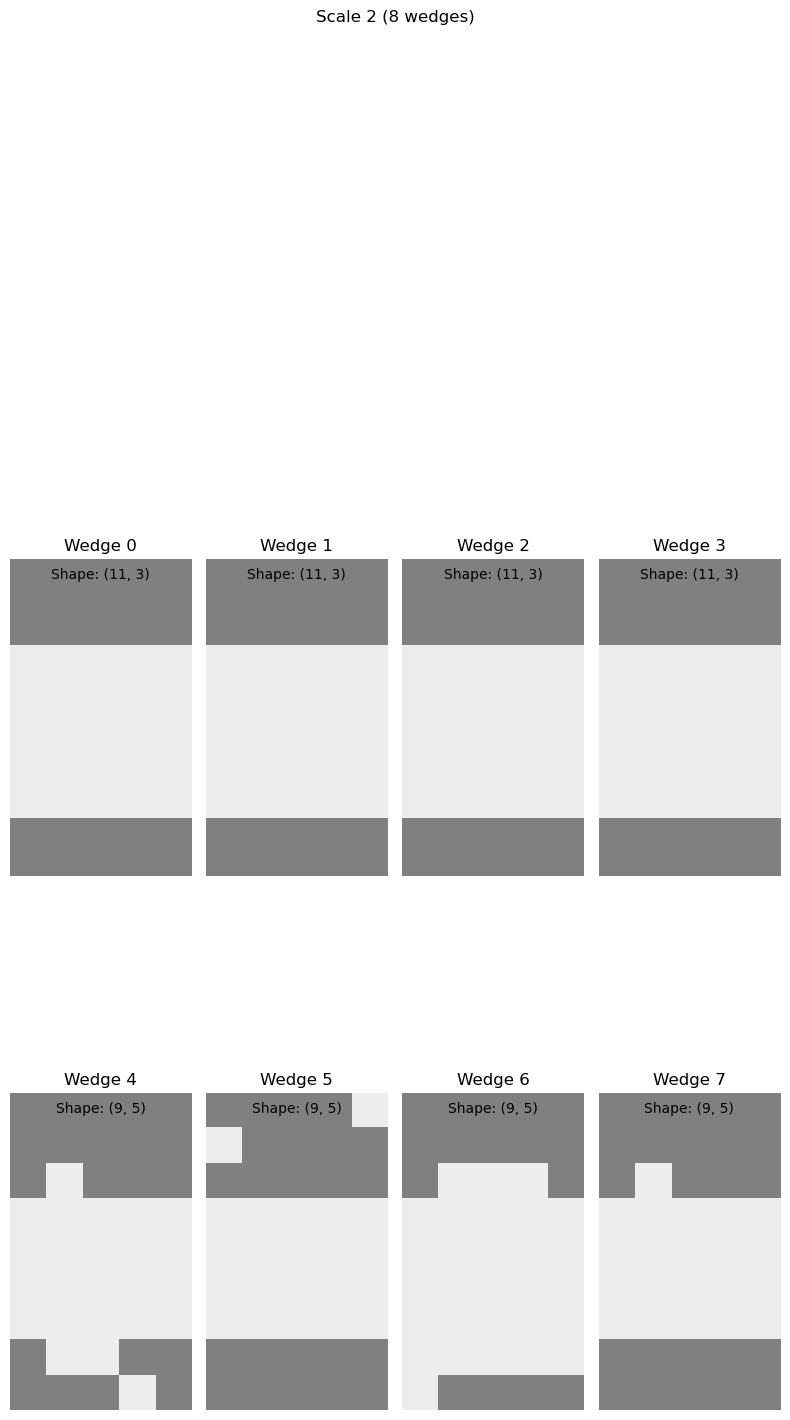

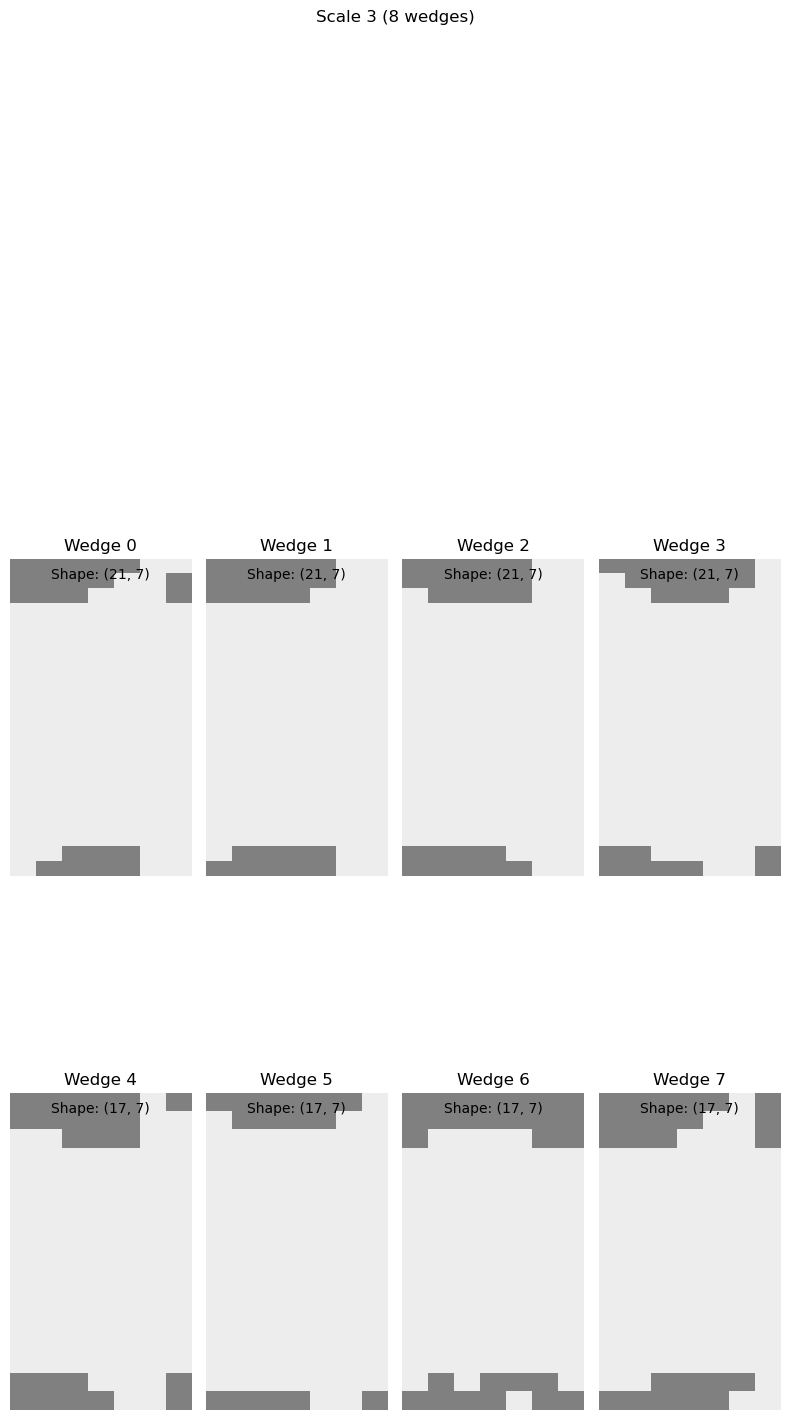

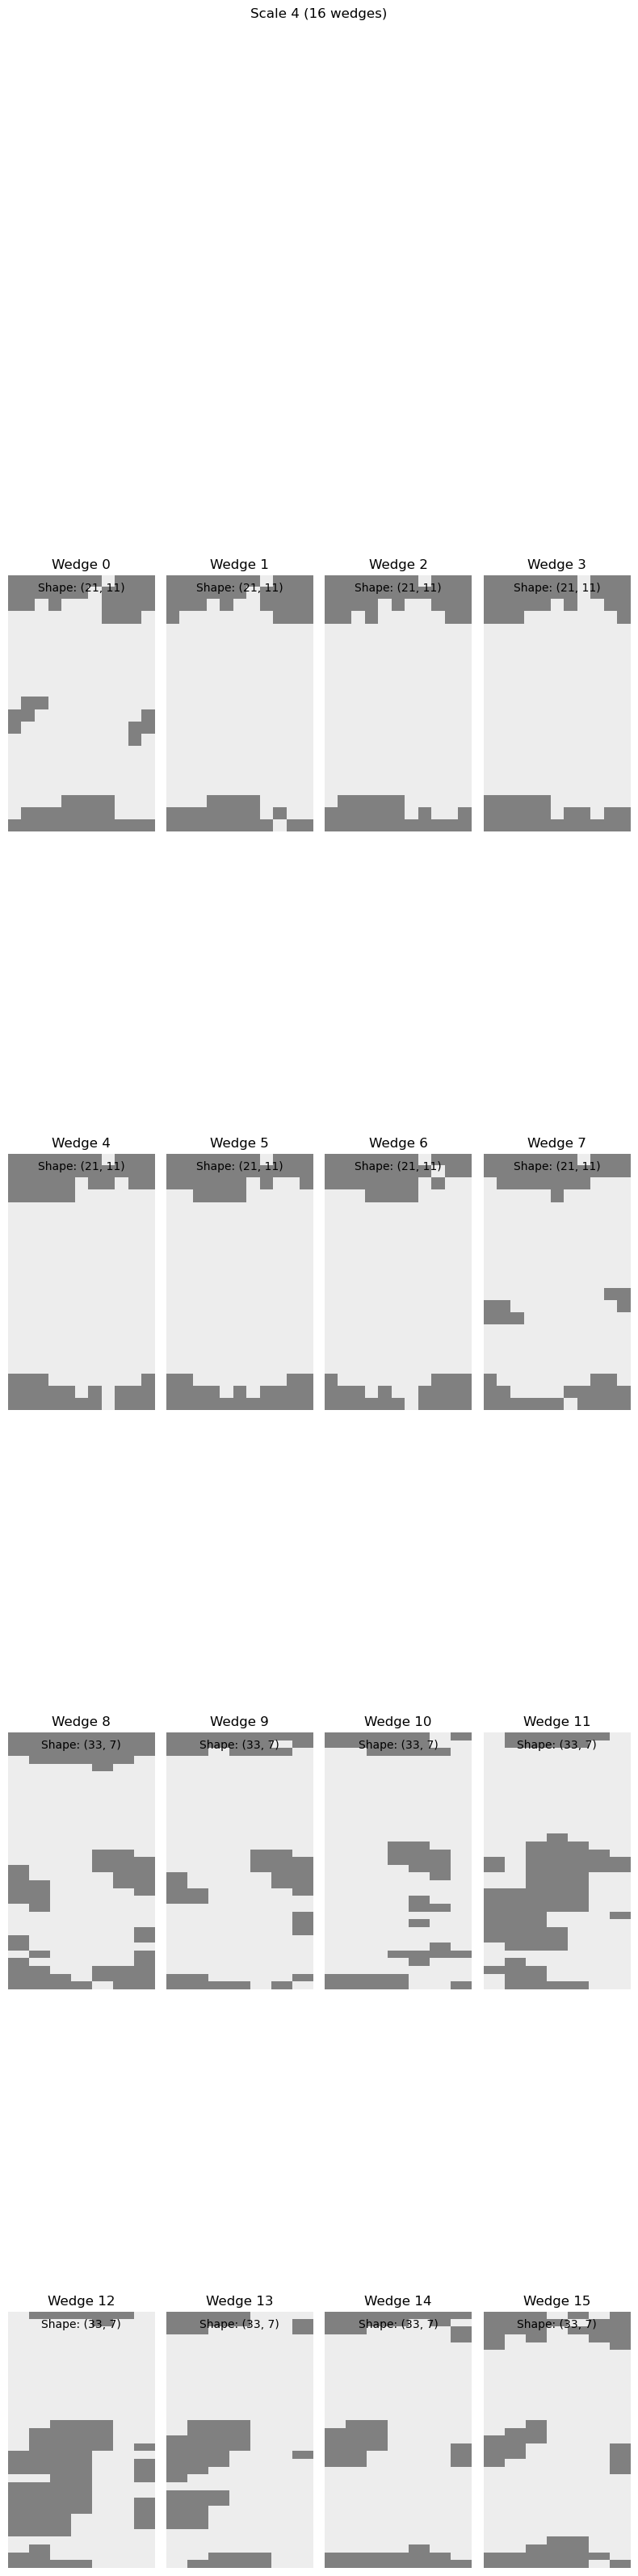

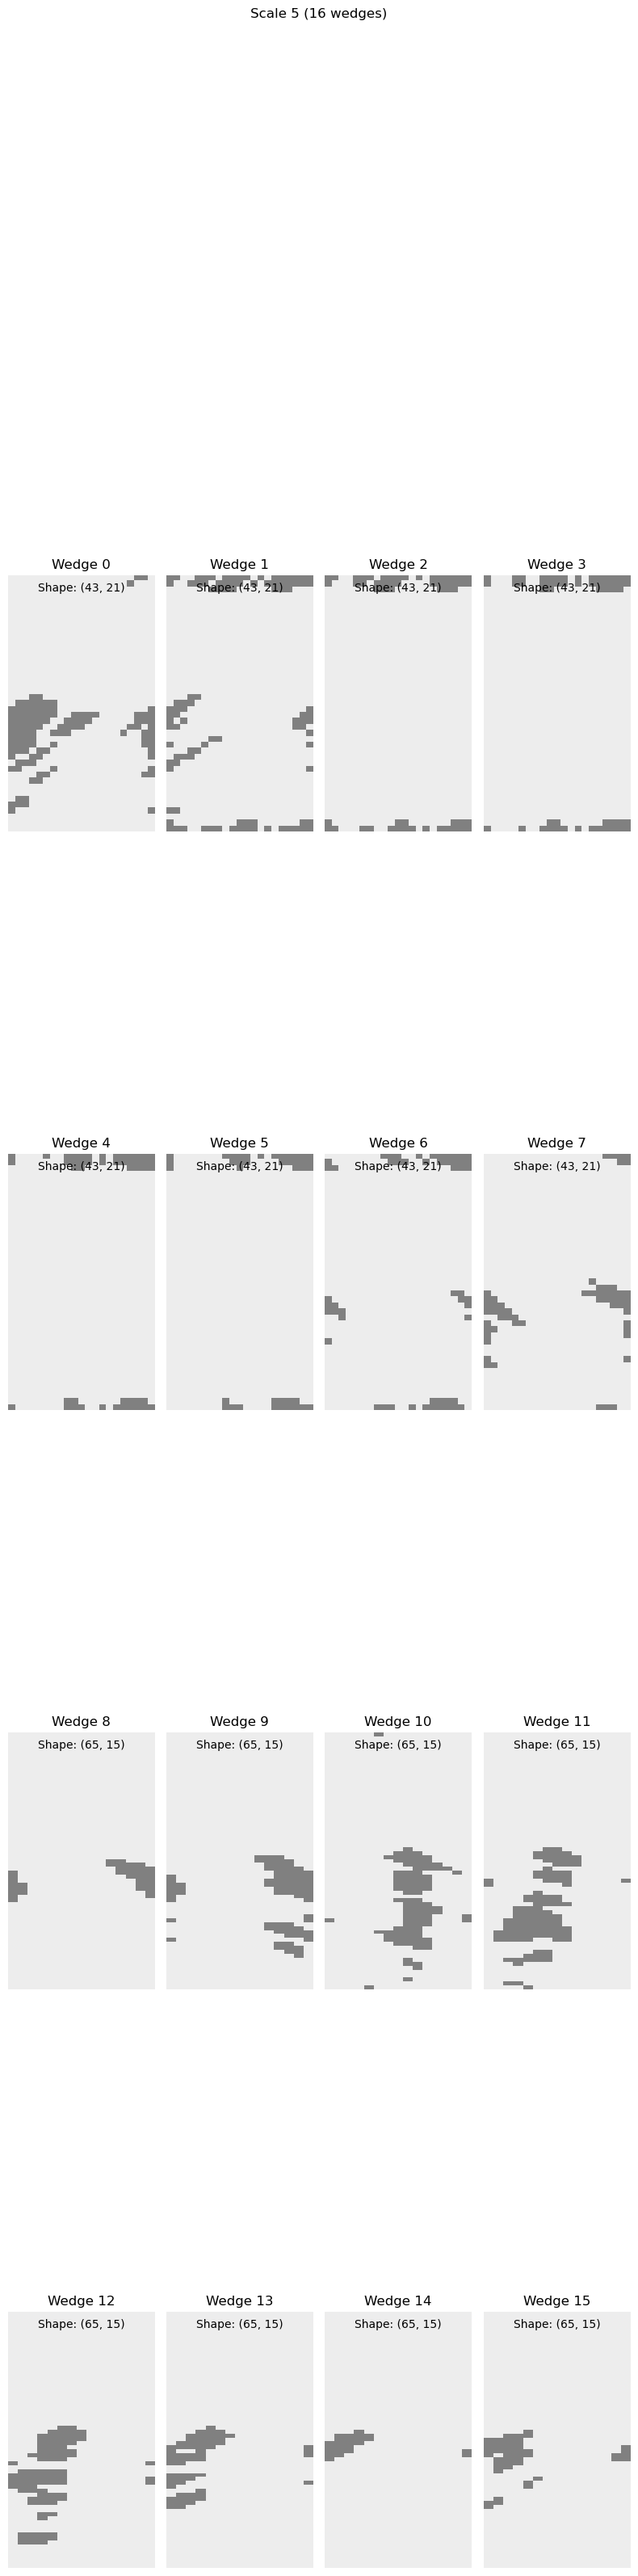

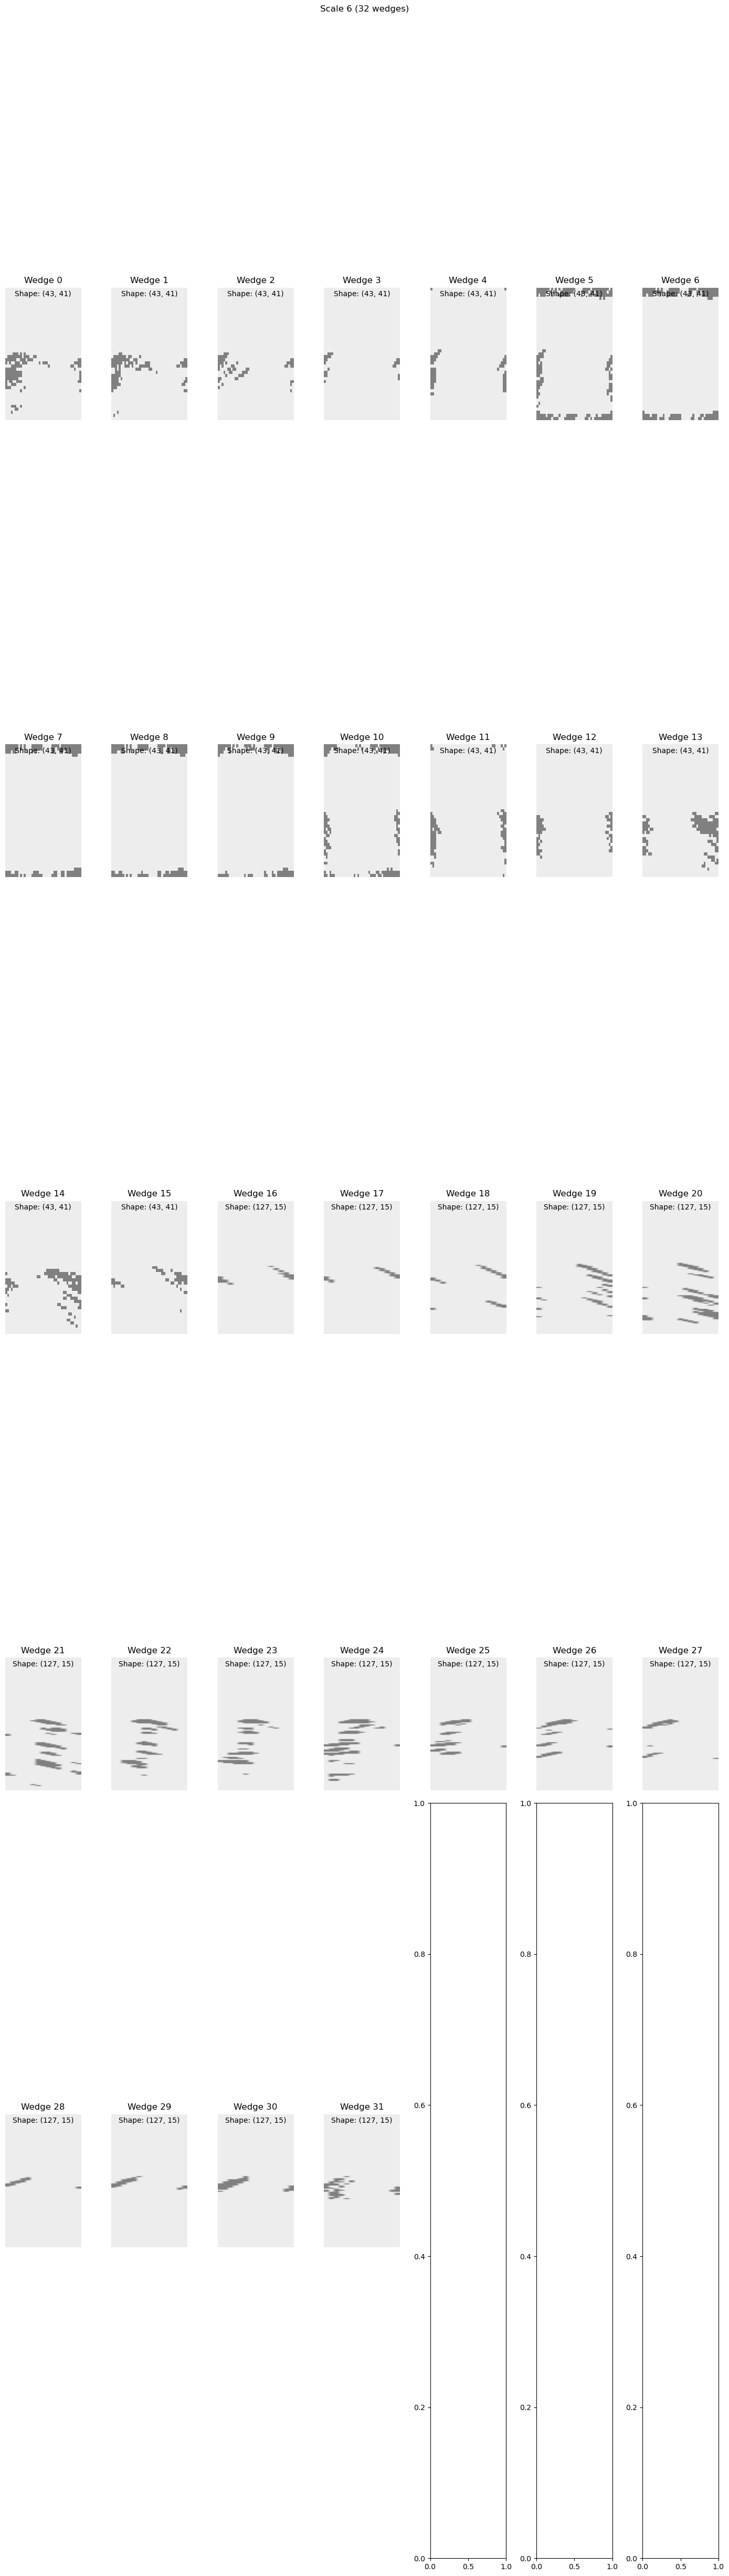

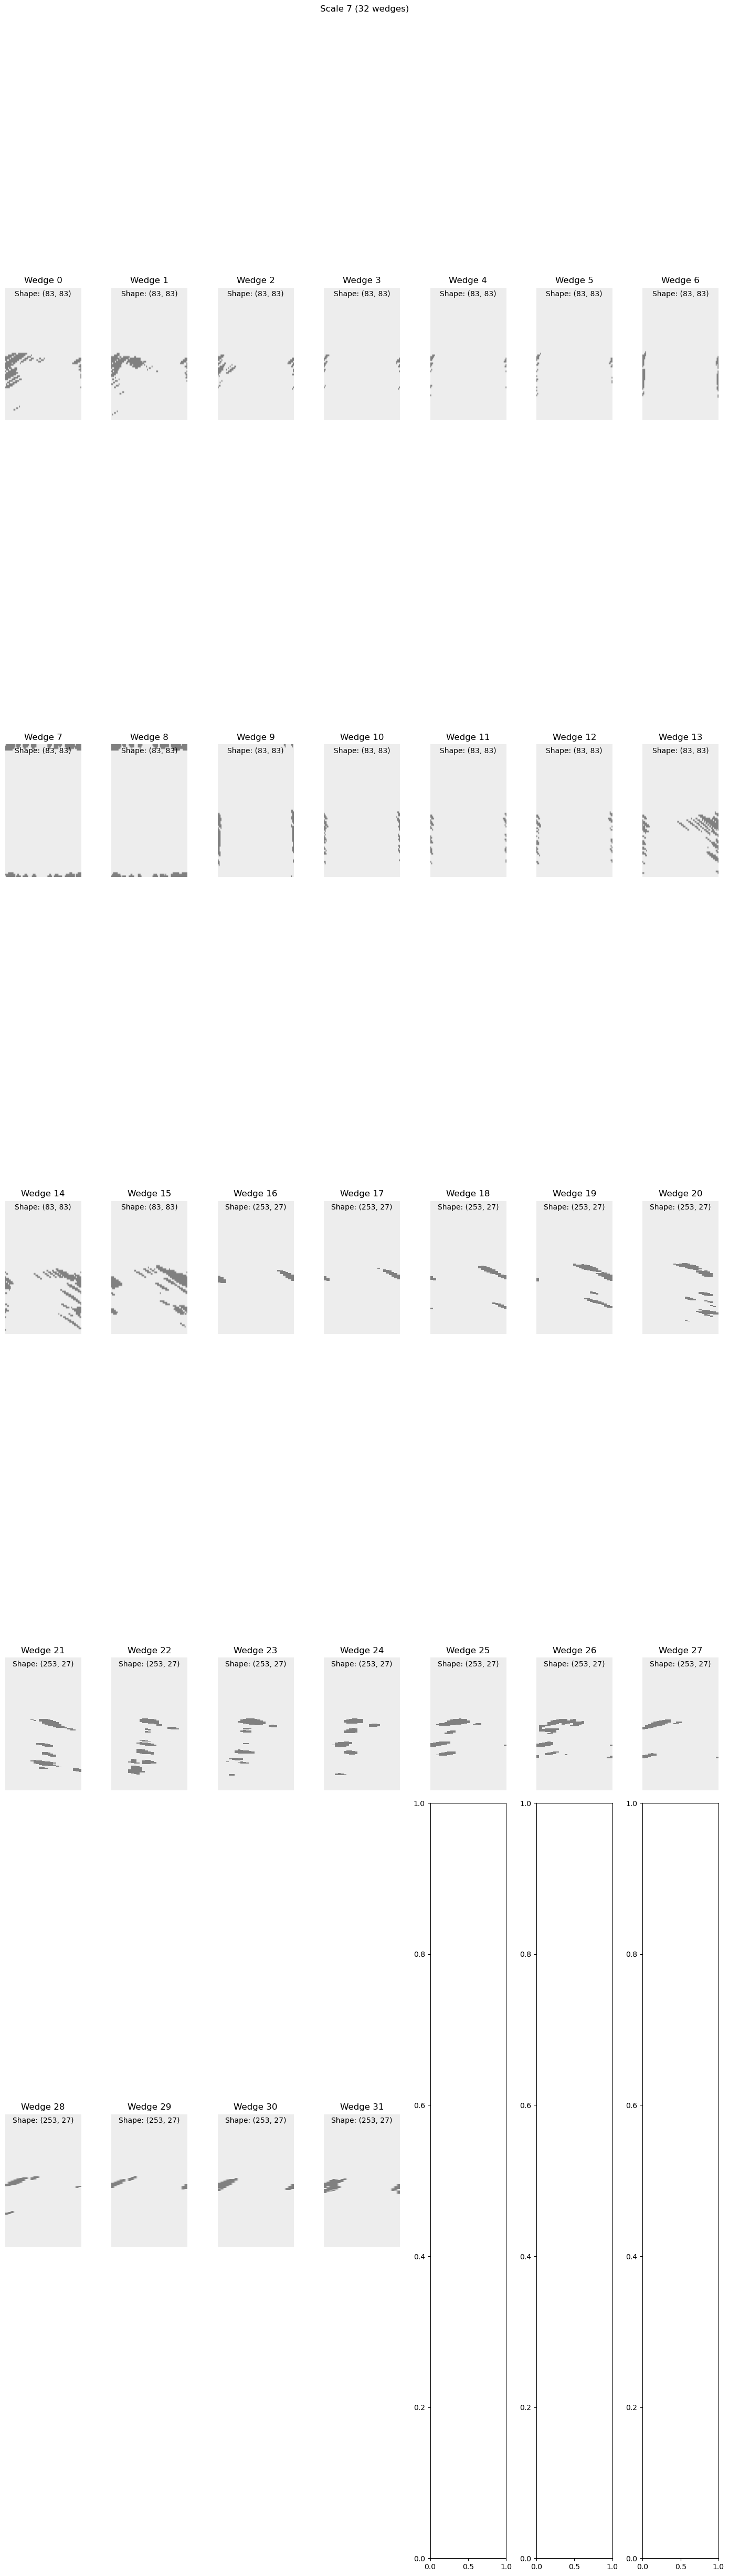

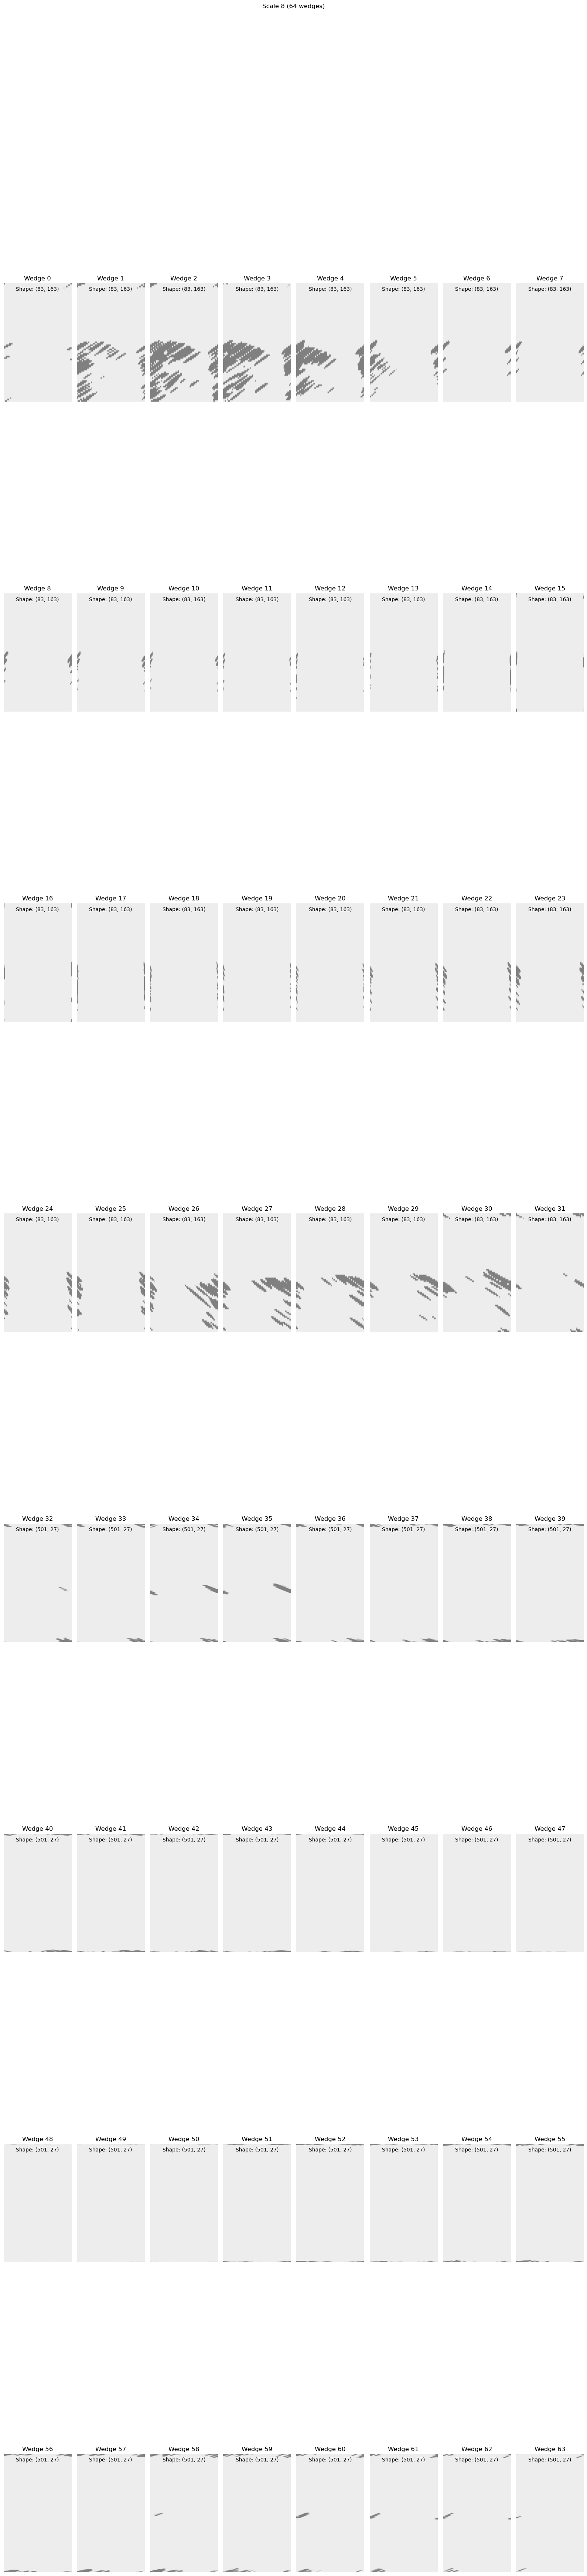

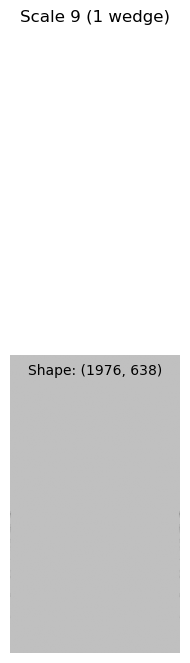

In [7]:
thr = 0.17
data_masked = curvelet_masking(data, multiples, thr=thr, scales=sc, wedges_num=w_n, plot_mask=True)

Relative error: 6.496 %


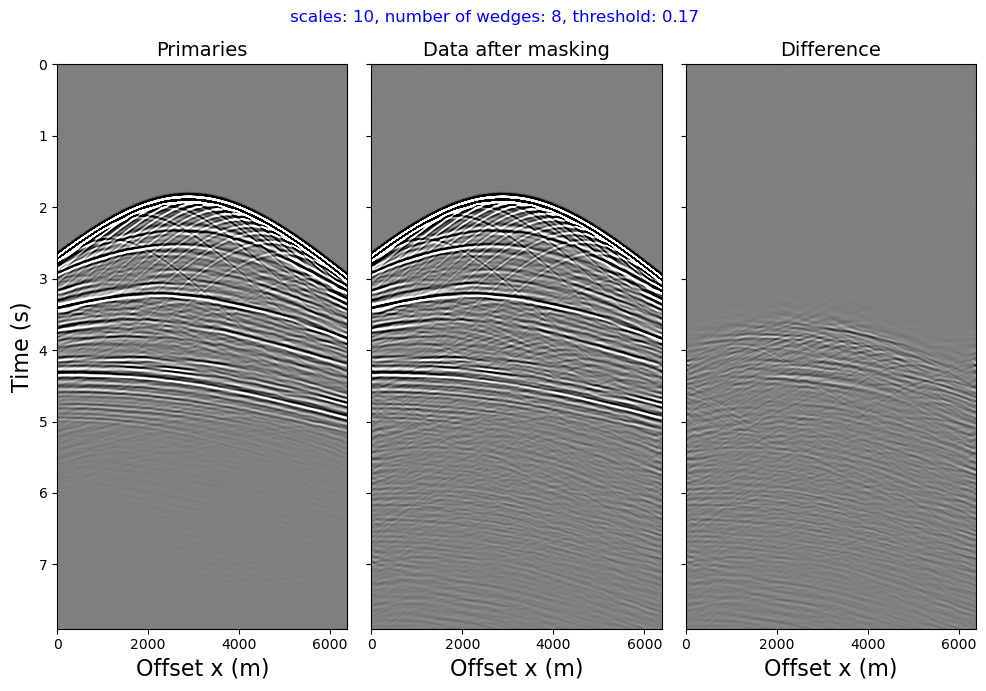

In [16]:
# Visualize shot gather
vmax = 0.04* np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (nt - 1) * dt
xmin = 0
xmax = nr*dx

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(primaries.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Primaries',fontsize=14)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)

axs[1].imshow(data_masked.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Data after masking',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow((data_masked-primaries).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.suptitle(f'scales: {sc}, number of wedges: {w_n}, threshold: {thr}', c='b')

print(f'Relative error: {round(np.linalg.norm(data_masked-primaries)*100/np.linalg.norm(primaries),3)} %')

plt.tight_layout()
plt.savefig('../figures/curvelet_masked.png', dpi=500)

We can compute the SNR in dB by the following relation:
$$ SNR = 20 * \log_{10} ( \frac{||\frac{s1_{real}}{||s1_{real}||_2}||_2}{||\frac{s1}{||s1||_2}-\frac{s1_{real}}{||s1_{real}||_2}||_2}) $$
where s1_real is the multiple-free data and s1 is the corrected primaries (data_masked).

In [30]:
snr = 20 * np.log10(np.linalg.norm(primaries/np.linalg.norm(primaries))/np.linalg.norm(data_masked/np.linalg.norm(data_masked)-primaries/np.linalg.norm(primaries)))
print('Signal to noise ratio: ', round(snr,2), 'dB')

Signal to noise ratio:  23.74 dB


Next, let's do the **bayes separation** in the curvelet domain. Similarly, we use the corrupted SRME multiples, as we would do in a real life scenario.

In [9]:
# Input parameters
eps1 = 1
eps2 = 0.1
eta = 1

# Apply bayes separation algorithm (Saab et al. 2007)
s1  = curvelet_separation(C2D, data, multiples, eps1, eps2, eta, niter=30)

Relative error: 4.241 %


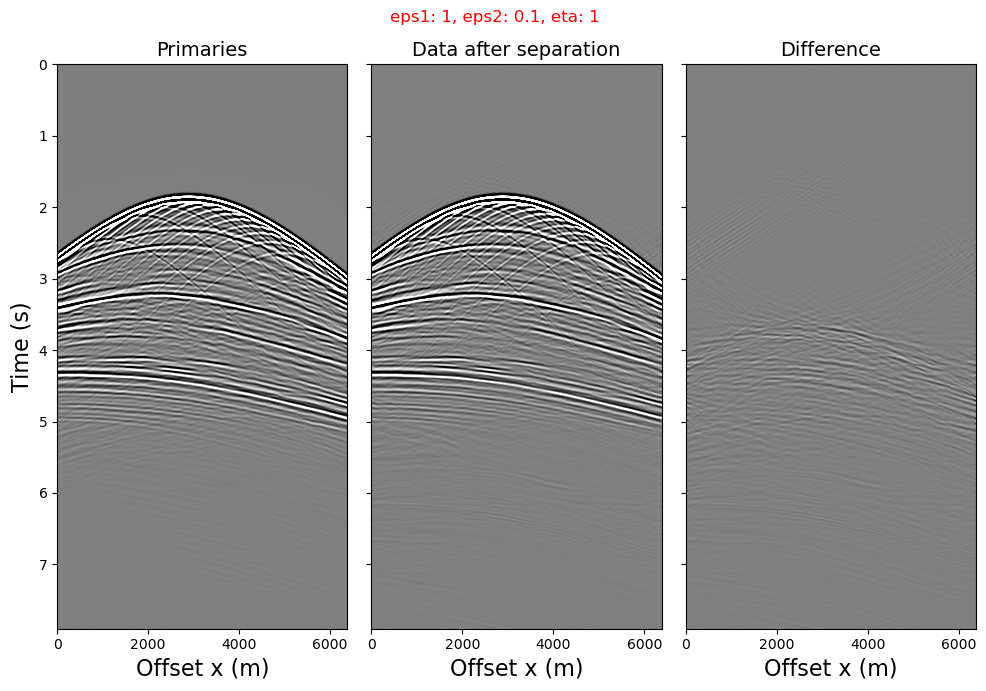

In [15]:
# Visualize shot gather
vmax = 0.04* np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (nt - 1) * dt
xmin = 0
xmax = nr*dx

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(primaries.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Primaries',fontsize=14)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)

axs[1].imshow(s1.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Data after separation',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow((s1-primaries).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.suptitle(f'eps1: {eps1}, eps2: {eps2}, eta: {eta}', c='r')

print(f'Relative error: {round(np.linalg.norm(s1-primaries)*100/np.linalg.norm(primaries),3)} %')

plt.tight_layout()
plt.savefig('../figures/curvelet_separation.png', dpi=500)

The algorithm is clearly supressing the multiples, although is also blanking the primaries to a small extent in the intersection areas (around 1.3 seg), and we can also notice some noise near to the first arrivals. The SNR is higher than for the masked data, and almost the same as the SNR obtained with the ADMM adaptive subtraction.

In [26]:
snr = 20 * np.log10(np.linalg.norm(s1_real/np.linalg.norm(s1_real))/np.linalg.norm(s1/np.linalg.norm(s1)-s1_real/np.linalg.norm(s1_real)))
print('Signal to noise ratio: ', round(snr,2), 'dB')

Signal to noise ratio:  27.47 dB
